# <center>Qubit demos - working with a real qubit

The measurements in this notebook were used for the QICK paper https://arxiv.org/abs/2110.00557.
    
**These measurements were made a while ago, and the QICK API has changed a lot in the meantime. We try to keep this demo up to date and we make sure it runs, but we cannot guarantee that it still behaves correctly when connected to a real qubit.**
    
*It's recommended to look at the other demos to get an understanding of how the QICK programs in this demo work. You will learn things that you should know when writing your own programs.*

The following collections of QICK measurement code (shared by QICK collaborators) may also be helpful:
* [Connie Miao, Schuster Lab](https://github.com/conniemiao/slab_rfsoc_expts)
* [Chao Zhou, Hatlab](https://github.com/PITT-HATLAB/Hatlab_RFSOC)
* [Sara Sussman, Houck Lab](https://github.com/sarafs1926/qick-amo)


In [1]:
%pylab inline
from qick import *
from tqdm.notebook import tqdm

Populating the interactive namespace from numpy and matplotlib


# Helper functions

In [2]:
#Figure params
rcParams['figure.figsize'] = 16, 8
rcParams.update({'font.size': 22})

#helper functions
def hist(data=None, plot=True, ran=1.0):
    
    ig = data[0]
    qg = data[1]
    ie = data[2]
    qe = data[3]

    numbins = 200
    
    xg, yg = np.median(ig), np.median(qg)
    xe, ye = np.median(ie), np.median(qe)

    if plot==True:
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
        fig.tight_layout()

        axs[0].scatter(ig, qg, label='g', color='b', marker='*')
        axs[0].scatter(ie, qe, label='e', color='r', marker='*')
        axs[0].scatter(xg, yg, color='k', marker='o')
        axs[0].scatter(xe, ye, color='k', marker='o')
        axs[0].set_xlabel('I (a.u.)')
        axs[0].set_ylabel('Q (a.u.)')
        axs[0].legend(loc='upper right')
        axs[0].set_title('Unrotated')
        axs[0].axis('equal')
    """Compute the rotation angle"""
    theta = -np.arctan2((ye-yg),(xe-xg))
    """Rotate the IQ data"""
    ig_new = ig*np.cos(theta) - qg*np.sin(theta)
    qg_new = ig*np.sin(theta) + qg*np.cos(theta) 
    ie_new = ie*np.cos(theta) - qe*np.sin(theta)
    qe_new = ie*np.sin(theta) + qe*np.cos(theta)
    
    """New means of each blob"""
    xg, yg = np.median(ig_new), np.median(qg_new)
    xe, ye = np.median(ie_new), np.median(qe_new)
    
    #print(xg, xe)
    
    xlims = [xg-ran, xg+ran]
    ylims = [yg-ran, yg+ran]

    if plot==True:
        axs[1].scatter(ig_new, qg_new, label='g', color='b', marker='*')
        axs[1].scatter(ie_new, qe_new, label='e', color='r', marker='*')
        axs[1].scatter(xg, yg, color='k', marker='o')
        axs[1].scatter(xe, ye, color='k', marker='o')    
        axs[1].set_xlabel('I (a.u.)')
        axs[1].legend(loc='lower right')
        axs[1].set_title('Rotated')
        axs[1].axis('equal')

        """X and Y ranges for histogram"""
        
        ng, binsg, pg = axs[2].hist(ig_new, bins=numbins, range = xlims, color='b', label='g', alpha=0.5)
        ne, binse, pe = axs[2].hist(ie_new, bins=numbins, range = xlims, color='r', label='e', alpha=0.5)
        axs[2].set_xlabel('I(a.u.)')       
        
    else:        
        ng, binsg = np.histogram(ig_new, bins=numbins, range = xlims)
        ne, binse = np.histogram(ie_new, bins=numbins, range = xlims)

    """Compute the fidelity using overlap of the histograms"""
    contrast = np.abs(((np.cumsum(ng) - np.cumsum(ne)) / (0.5*ng.sum() + 0.5*ne.sum())))
    tind=contrast.argmax()
    threshold=binsg[tind]
    fid = contrast[tind]
    axs[2].set_title(f"Fidelity = {fid*100:.2f}%")

    return fid, threshold, theta

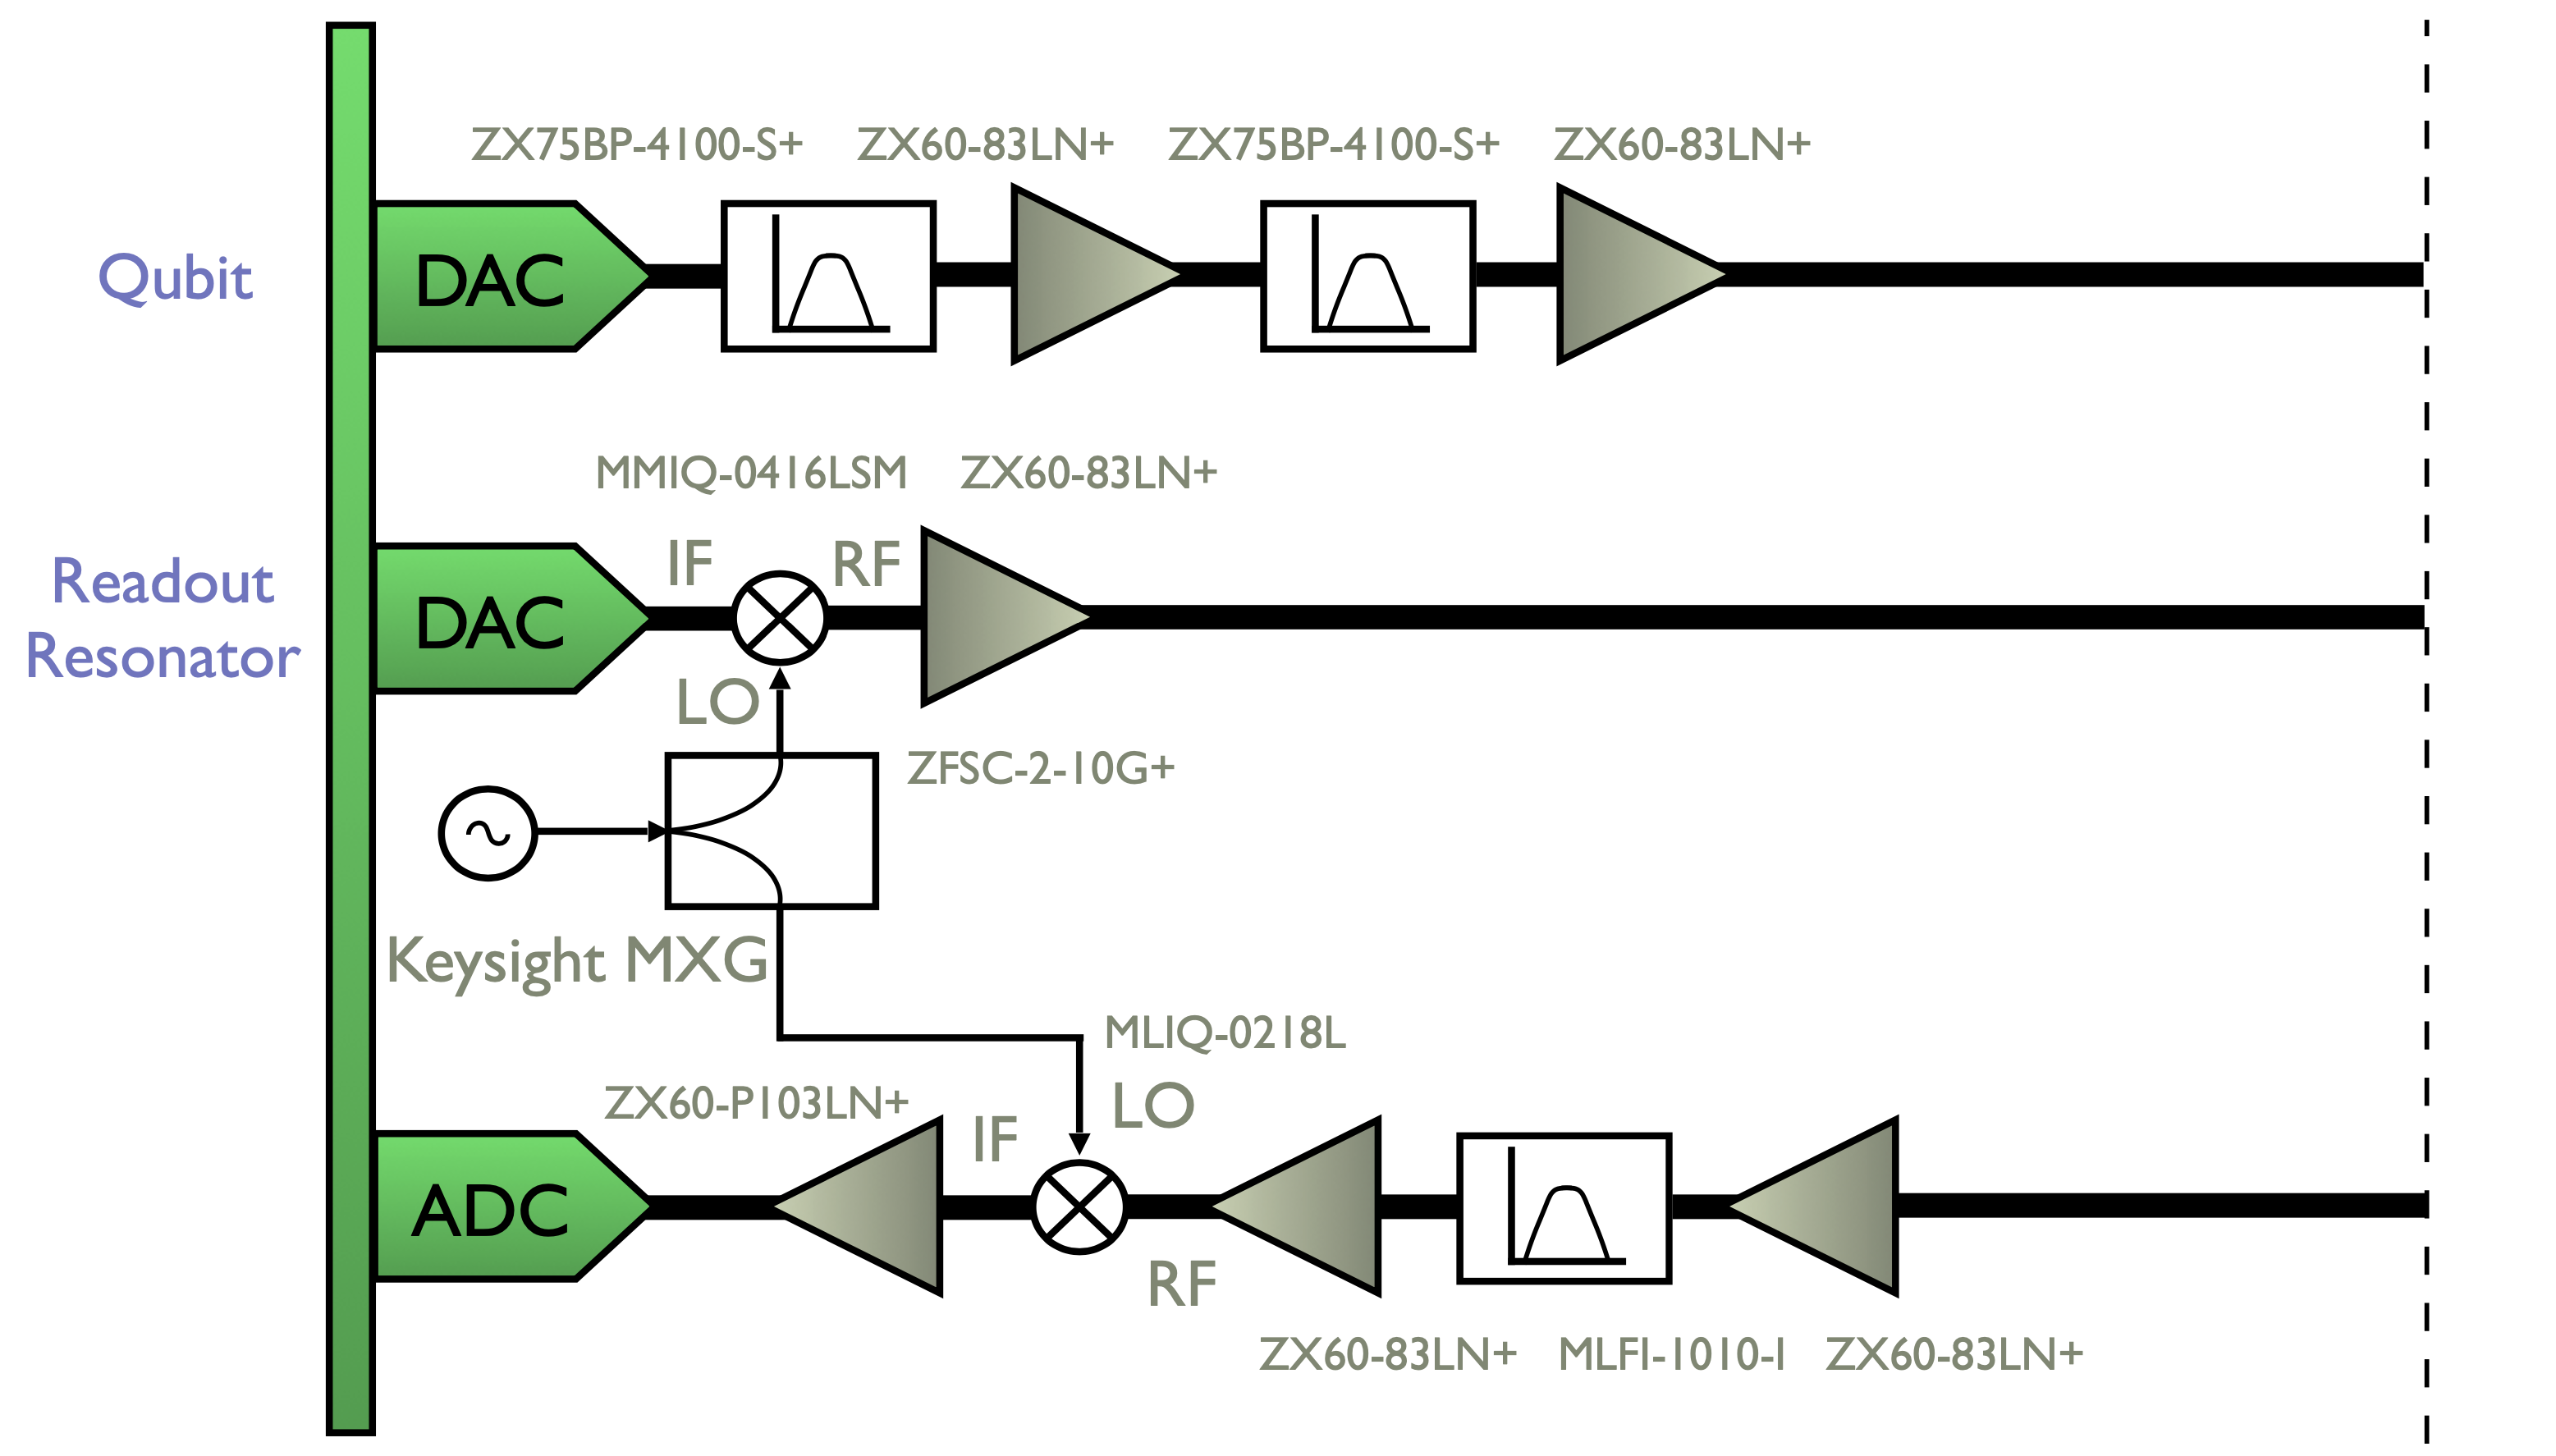

In [1]:
from IPython.display import Image, display
display(Image(filename='images/QICK_wiring_new.png', embed=True))

# Configuring the channels

The data in this notebook was taken with a wiring diagram similar to the above. The QICK has eight RF DACs which can be configured in multiple ways. Using the QICK, two RF DACs are needed to control the qubit and its readout resonator, respectively. Also, the qubit control pulses (< 6 GHz) were directly synthesized without the use of an analog mixer. Note that the QICK RF board was not used for these measurements, only the ZCU111 evaluation board plus the analog components specified in the diagram.

In [3]:
# Load bitstream with custom overlay
soc = QickSoc()
# Since we're running locally on the QICK, we don't need a separate QickConfig object.
# If running remotely, you could generate a QickConfig from the QickSoc:
#     soccfg = QickConfig(soc.get_cfg())
# or save the config to file, and load it later:
#     with open("qick_config.json", "w") as f:
#         f.write(soc.dump_cfg())
#     soccfg = QickConfig("qick_config.json")
soccfg = soc

hw_cfg={"jpa_ch":6,
        "res_ch":5,
        "qubit_ch":2,
        "storage_ch":0
       }
readout_cfg={
    "readout_length":soccfg.us2cycles(3.0, gen_ch=5), # [Clock ticks]
    "f_res": 99.775 +0.18, # [MHz]
    "res_phase": 0,
    "adc_trig_offset": 275, # [Clock ticks]
    "res_gain":10000
    }
qubit_cfg={
    "sigma":soccfg.us2cycles(0.025, gen_ch=2),
    "pi_gain": 11500,
    "pi2_gain":11500//2, 
    "f_ge":4743.041802067813,
    "relax_delay":500
}

# TOF Measurement

Measures the "time of flight" of the measurement pulse. The time of flight is the time at which the measurement pulse appears in the ADC buffer. We only want to start capturing data from this point in time onwards. We store this time of flight in the parameter <code> readout_cfg["adc_trig_offset"] </code>.

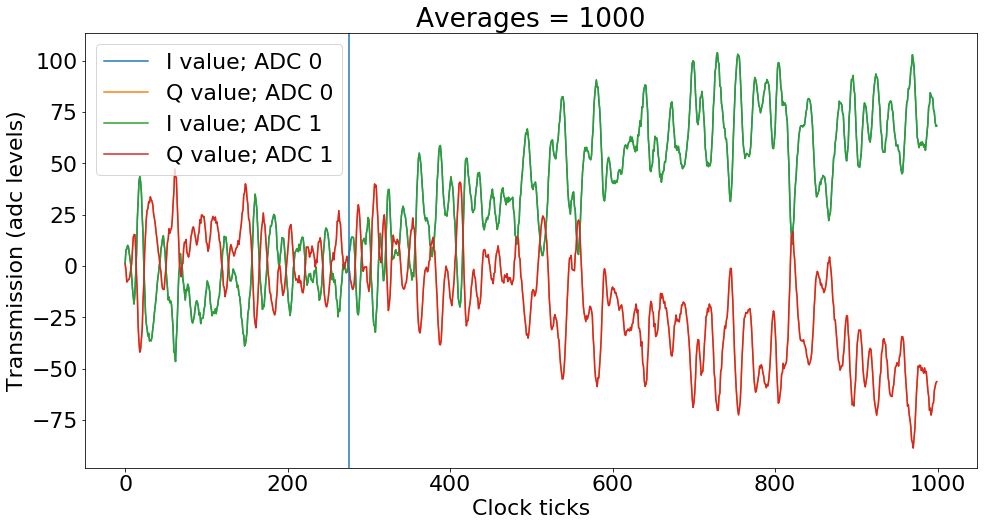

In [4]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
#         self.declare_gen(ch=cfg["jpa_ch"], nqz=1) #JPA
        self.declare_gen(ch=cfg["res_ch"], nqz=1) #Readout
#         self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
#         self.declare_gen(ch=cfg["storage_ch"], nqz=2) #Storage

        for ch in [0,1]: #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["frequency"], gen_ch=cfg["res_ch"])

        freq=self.freq2reg(cfg["frequency"], gen_ch=cfg["res_ch"], ro_ch=0)  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=freq, phase=0, gain=cfg["pulse_gain"],
                                length=cfg["pulse_length"])
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        cfg=self.cfg   
        self.measure(pulse_ch=cfg["res_ch"], 
             adcs=[0,1],
             adc_trig_offset=cfg["adc_trig_offset"],
             t=0,
             wait=True,
             syncdelay=self.us2cycles(cfg["relax_delay"]))        

expt_config={
        "reps":1, # --Fixed
        "pulse_length":600, # [Clock ticks]
        "readout_length":1000, # [Clock ticks]
        "pulse_gain":5000, # [DAC units]
        "frequency": 100, # [MHz]
        "adc_trig_offset": 0, # [Clock ticks]
        "soft_avgs":1000
       }

config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_config}
prog =LoopbackProgram(soccfg, config)
adc1, adc2 = prog.acquire_decimated(soc, progress=True)

# Plot results.
subplot(111, title=f"Averages = {config['soft_avgs']}", xlabel="Clock ticks", ylabel="Transmission (adc levels)")
plot(adc1[0], label="I value; ADC 0")
plot(adc1[1], label="Q value; ADC 0")
plot(adc2[0], label="I value; ADC 1")
plot(adc2[1], label="Q value; ADC 1")
legend()
axvline(readout_cfg["adc_trig_offset"])

# Single tone (Resonator) Spectroscopy

Measures the resonant frequency of the readout resonator when the qubit is in its ground state. We store this resonant frequency in the parameter <code> readout_cfg["f_res"] </code>.

In [5]:
class SingleToneSpectroscopyProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        self.declare_gen(ch=cfg["res_ch"], nqz=1) #Readout
        for ch in [0,1]: #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["frequency"], gen_ch=cfg["res_ch"])
        
        freq=self.freq2reg(cfg["frequency"], gen_ch=cfg["res_ch"], ro_ch=0)  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=freq, phase=0, gain=cfg["res_gain"],
                                length=cfg["readout_length"])

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[0,1],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))        

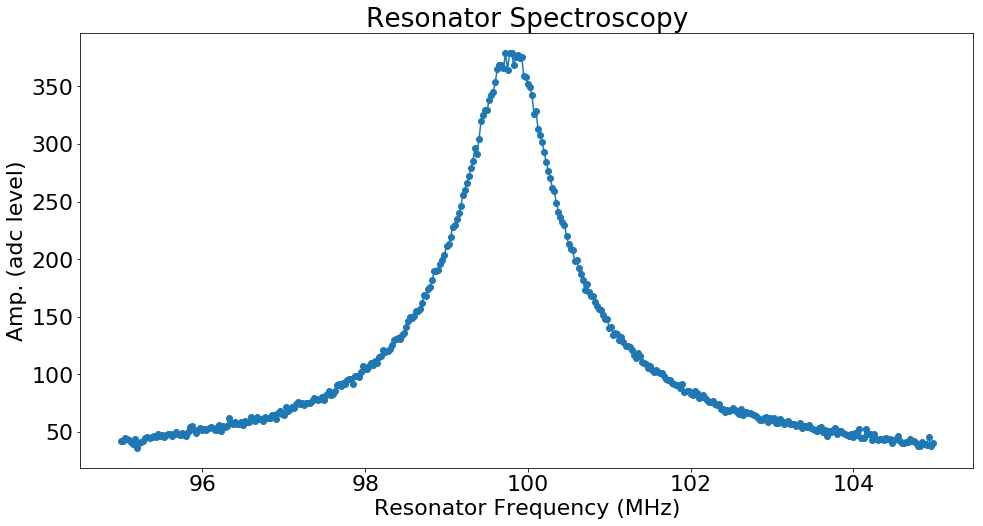

In [6]:
expt_cfg={"reps":500, "relax_delay":10,
          "start":95, "step":0.025, "expts":400
         }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs

fpts=expt_cfg["start"] + expt_cfg["step"]*np.arange(expt_cfg["expts"])

amps=[]
for f in tqdm(fpts):
    config["frequency"]=f

    rspec=SingleToneSpectroscopyProgram(soccfg, config)
    avgi,avgq=rspec.acquire(soc)
    amp=np.abs(avgi[0][0]+1j*avgq[0][0])
    amps.append(amp)
amps=np.array(amps)

plt.subplot(111,title="Resonator Spectroscopy", xlabel="Resonator Frequency (MHz)", ylabel="Amp. (adc level)")
plt.plot(fpts, amps,'o-')
max_freq=fpts[np.argmax(amps)]
plt.show()

# Single Shot

Measures the single shot readout fidelity of the system. We acquire single shot (I, Q) readout values by first preparing the qubit in its ground (blue dots) a certain number of times (in the below demo we take 5000 shots) and then preparing the qubit in its excited state (red dots) the same number of times. We then extract two parameters which are used to optimize the associated readout fidelity: the rotation angle of the IQ blobs and the threshold that classifies the two qubit states (ground and excited). We store these two parameters here <code> readout_cfg["res_phase"] </code> and <code> readout_cfg["threshold"] </code>.

Note that this experiment already assumes that you have found your qubit frequency and $\pi$ pulse amplitude. It is placed towards the top of this demo notebook because every time you reset the QICK firmware the single shot angle and threshold changes. So, this experiment is used to calibrate any experiment below that uses single shot data (such as the Active Reset experiment).

In [7]:
class SingleShotProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.declare_gen(ch=cfg["res_ch"], nqz=1) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]: #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["res_ch"])

        cfg["start"]=0
        cfg["step"]=cfg["pi_gain"]
        cfg["reps"]=cfg["shots"]
        cfg["expts"]=2
        
        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_gain=self.sreg(cfg["qubit_ch"], "gain")   # get frequency register for qubit_ch    
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=0) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])
        
        # add qubit and readout pulses to respective channels
        self.add_gauss(ch=cfg["qubit_ch"], name="qubit", sigma=cfg["sigma"], length=cfg["sigma"]*4)
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=f_ge, phase=0, gain=cfg["start"], 
                                 waveform="qubit")
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=cfg["readout_length"])

        self.sync_all(self.us2cycles(500))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05)) # align channels and wait 50ns

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[0,1],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))
    
    def update(self):
        self.mathi(self.q_rp, self.r_gain, self.r_gain, '+', self.cfg["step"]) # update frequency list index
        
    def acquire(self,soc, progress=False):
        super().acquire(soc, progress=progress)
        return self.collect_shots()
        
    def collect_shots(self):
        shots_i0=self.di_buf[0].reshape((self.cfg["expts"],self.cfg["reps"]))/self.cfg['readout_length']
        shots_q0=self.dq_buf[0].reshape((self.cfg["expts"],self.cfg["reps"]))/self.cfg['readout_length']
        shots_i1=self.di_buf[1].reshape((self.cfg["expts"],self.cfg["reps"]))/self.cfg['readout_length']
        shots_q1=self.dq_buf[1].reshape((self.cfg["expts"],self.cfg["reps"]))/self.cfg['readout_length']
        return shots_i0,shots_q0,shots_i1,shots_q1
        
    def analyze(self, shots_i, shots_q):
        plt.subplot(111, xlabel='I', ylabel='Q', title='Single Shot Histogram')
        plt.plot(shots_i[0],shots_q[0],'.',label='g')
        plt.plot(shots_i[1],shots_q[1],'.',label='e')
        plt.legend()
        plt.gca().set_aspect('equal', 'datalim')

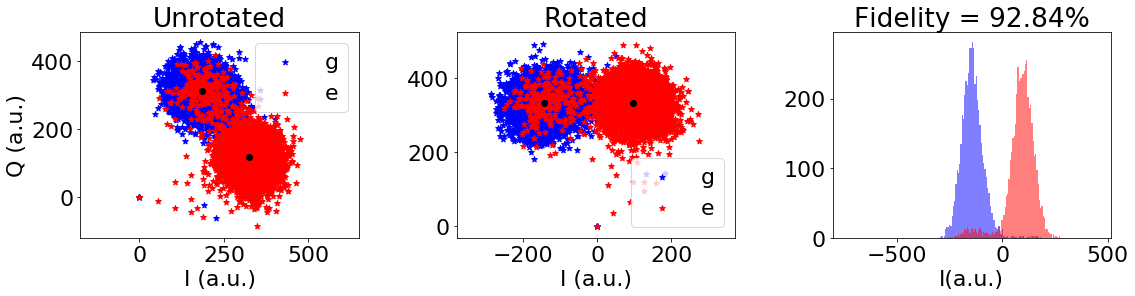

In [8]:
expt_cfg={
        "shots":5000, "res_phase":0
       }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs

ssp=SingleShotProgram(soccfg, config)
di0, dq0, di1, dq1 = ssp.acquire(soc,progress=True)

fid, threshold, angle = hist(data=[di0[0], dq0[0], di0[1], dq0[1]],  plot=True, ran=600)
#print('Optimal fidelity after rotation = %.3f' % fid)
readout_cfg["res_phase"]=soccfg.deg2reg(-angle*180/pi, gen_ch=5)
readout_cfg["threshold"]=round(threshold)

# Pulse Probe (qubit) spectroscopy

Measures the qubit frequency f_ge. We store this parameter here: <code> qubit_cfg["f_ge"] </code>.

This program uses the RAveragerProgram class, which allows you to sweep a parameter directly on the processor rather than in a Python loop as in the above resonator spectroscopy example. Because the whole sweep is done on the processor there is less downtime (especially for fast experiments).

In [9]:
class PulseProbeSpectroscopyProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.declare_gen(ch=cfg["res_ch"], nqz=1) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]: #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["res_ch"])

        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_freq=self.sreg(cfg["qubit_ch"], "freq")   # get frequency register for qubit_ch    
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=0) # conver f_res to dac register value

        self.f_start =self.freq2reg(cfg["start"], gen_ch=cfg["qubit_ch"])  # get start/step frequencies
        self.f_step =self.freq2reg(cfg["step"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="const", freq=self.f_start, phase=0, gain=cfg["qubit_gain"], 
                                 length=cfg["probe_length"])
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=cfg["readout_length"])
        
        self.sync_all(self.us2cycles(1))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05)) # align channels and wait 50ns

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[0,1],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

    def update(self):
        self.mathi(self.q_rp, self.r_freq, self.r_freq, '+', self.f_step) # update frequency list index

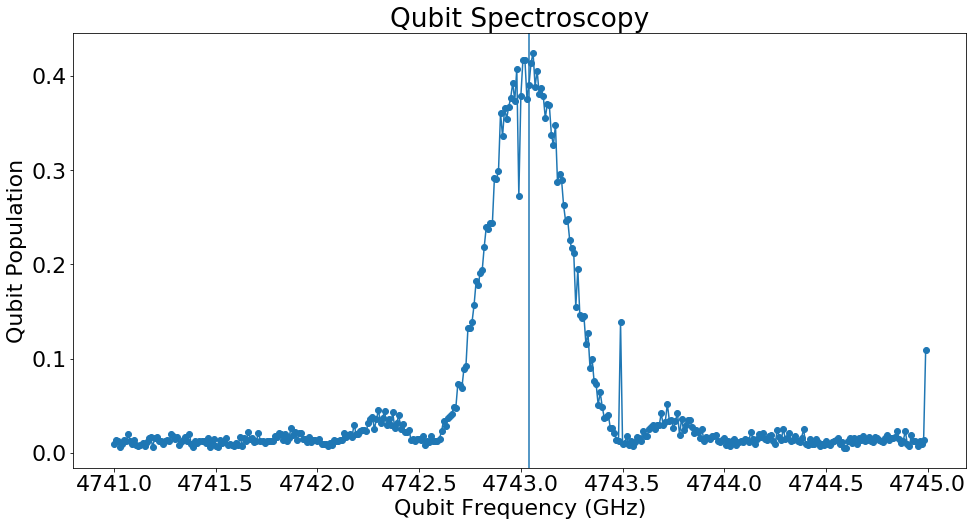

In [10]:
expt_cfg={"start":4741, "step":0.01, "expts":400, "reps": 20,"rounds":50,
          "probe_length":soccfg.us2cycles(2.0, gen_ch=2), "qubit_gain":10
         }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs

qspec=PulseProbeSpectroscopyProgram(soccfg, config)
expt_pts, avgi, avgq = qspec.acquire(soc, threshold=readout_cfg["threshold"],progress=True)

subplot(111,title="Qubit Spectroscopy", xlabel="Qubit Frequency (GHz)", ylabel="Qubit Population")
plot(expt_pts, avgi[0][0],'o-')
axvline(qubit_cfg["f_ge"]);

# Length Rabi

Measures Rabi oscillations by sweeping over the duration of the qubit drive pulse. This is a preliminary measurement to prove that we see Rabi oscillations. This measurement is followed up by the Amplitude Rabi experiment below.

Note that we could speed up this measurement by using an RAveragerProgram (tProcessor loop over duration) instead of a AveragerProgram with a Python loop. We would need to update two registers, one for the pulse length and one for the sync after playing the pulse (sync_all automatically accounts for the pulse length if it's a fixed value, but that doesn't work if the pulse length is being modified by the tProcessor).

In [11]:
class LengthRabiProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg

        self.declare_gen(ch=cfg["res_ch"], nqz=1) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]: #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["res_ch"])
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=0) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="const", freq=f_ge, phase=0, gain=cfg["qubit_gain"], 
                                 length=cfg["pulse_length"])
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=cfg["readout_length"])

        self.synci(200)
        
    def body(self):
        cfg=self.cfg
        self.pulse(ch=cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05)) # align channels and wait 50ns

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=cfg["res_ch"], 
             adcs=[0,1],
             wait=True,
             syncdelay=self.us2cycles(cfg["relax_delay"]))

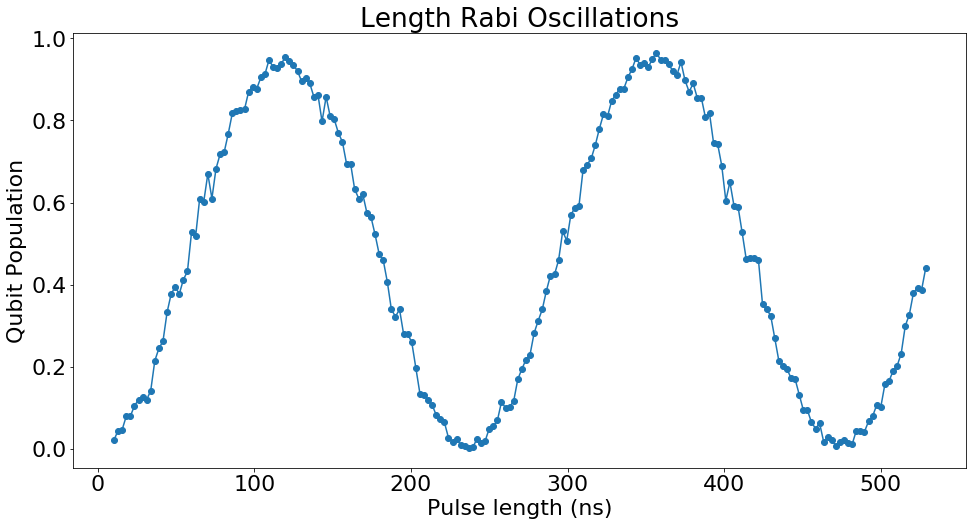

In [12]:
expt_cfg={
       "qubit_gain":2000,
        "start":4, "step":1, "expts":200, "reps": 400,
       }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs
expt_pts=[expt_cfg["start"] + ii*expt_cfg["step"] for ii in range(expt_cfg["expts"])]


results=[]
for length in tqdm(expt_pts):
    config["pulse_length"]=length

    rabi=LengthRabiProgram(soccfg, config)
    avgi,avgq = rabi.acquire(soc, threshold=readout_cfg["threshold"], progress=False)
    results.append(avgi[0][0])
    
subplot(111, title="Length Rabi Oscillations", xlabel="Pulse length (ns)", ylabel="Qubit Population")
plot(soccfg.cycles2us(np.array(expt_pts), gen_ch=2)*1000,results,'o-');

# Amplitude Rabi

Measures Rabi oscillations by sweeping over the amplitude of the qubit drive pulse, which is an $\approx$ 100 ns ($\sigma$ $\approx$ 25 ns) long Gaussian pulse. We measure the $\pi$ and $\pi$/2 pulse amplitudes which are used in subsequent experiments to control the qubit. We store these parameters here: <code> qubit_cfg["pi_gain"] </code> and <code> qubit_cfg["pi2_gain"] </code>

In [13]:
class AmplitudeRabiProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_gain=self.sreg(cfg["qubit_ch"], "gain")   # get gain register for qubit_ch    
        
        self.declare_gen(ch=cfg["res_ch"], nqz=1) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]: #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["res_ch"])
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=0) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.add_gauss(ch=cfg["qubit_ch"], name="qubit", sigma=cfg["sigma"], length=cfg["sigma"]*4)
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=f_ge, phase=self.deg2reg(90, gen_ch=cfg["qubit_ch"]), gain=cfg["start"], 
                                 waveform="qubit")
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=cfg["readout_length"])
        
        self.sync_all(self.us2cycles(500))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05)) # align channels and wait 50ns

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[0,1],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))
    
    def update(self):
        self.mathi(self.q_rp, self.r_gain, self.r_gain, '+', self.cfg["step"]) # update gain of the Gaussian pi pulse

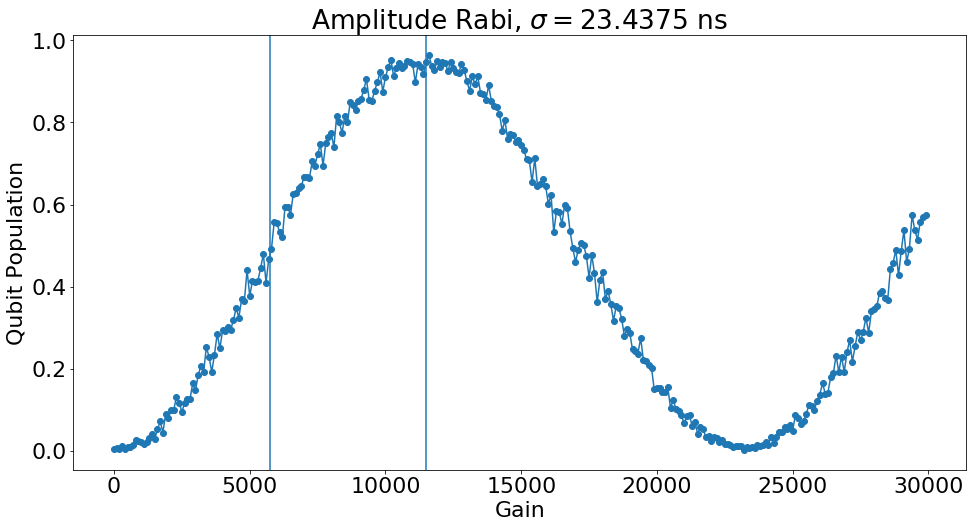

In [14]:
expt_cfg={
        "start":0, "step":100, "expts":300, "reps": 400
       }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs

rabi=AmplitudeRabiProgram(soccfg, config)
x_pts, avgi, avgq  = rabi.acquire(soc,threshold=readout_cfg["threshold"],progress=True)

subplot(111, title= f"Amplitude Rabi, $\sigma={soccfg.cycles2us(config['sigma'], gen_ch=2)*1000}$ ns", xlabel="Gain", ylabel="Qubit Population" )
plot(x_pts,avgi[0][0],'o-')

axvline(qubit_cfg["pi_gain"])
axvline(qubit_cfg["pi2_gain"]);

# T1 

Measures the qubit T1 characteristic decay time by preparing the qubit in its excited state with a $\pi$ pulse followed by a variable delay ($\tau$) before measuring the qubit's state. This exponential decay curve can be fitted in post-processing to obtain the qubit T1 time.

In [15]:
class T1Program(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_wait = 3
        self.regwi(self.q_rp, self.r_wait, cfg["start"])

        self.declare_gen(ch=cfg["res_ch"], nqz=1) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]: #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["res_ch"])
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=0) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.add_gauss(ch=cfg["qubit_ch"], name="qubit", sigma=cfg["sigma"], length=cfg["sigma"]*4)
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=f_ge, phase=0, gain=cfg["pi_gain"], 
                                 waveform="qubit")
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=cfg["readout_length"])

        self.sync_all(self.us2cycles(500))
    
    def body(self):
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all()
        self.sync(self.q_rp,self.r_wait)

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[0,1],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))
    
    def update(self):
        self.mathi(self.q_rp, self.r_wait, self.r_wait, '+', self.us2cycles(self.cfg["step"])) # update frequency list index

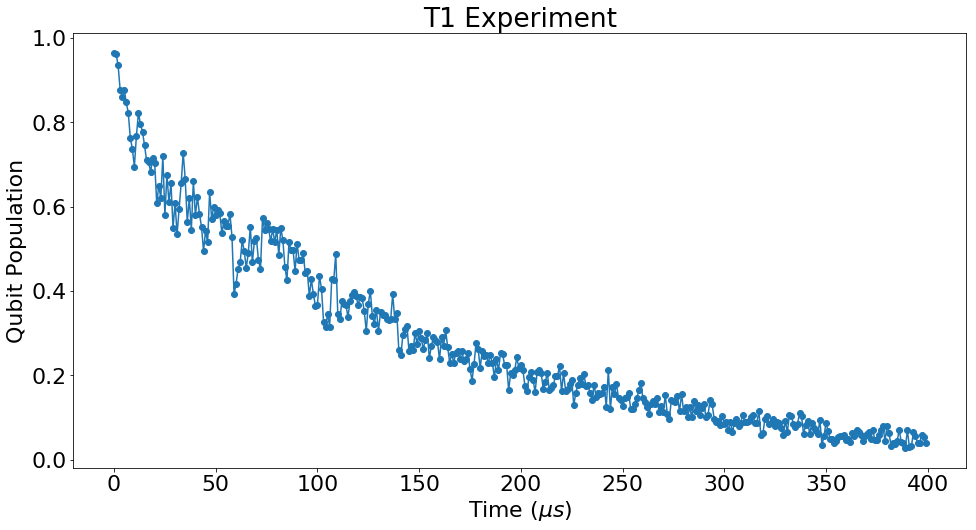

In [16]:
expt_cfg={ "start":0, "step":1, "expts":400, "reps": 400,
        "relax_delay":750
       }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs

t1p=T1Program(soccfg, config)

x_pts, avgi, avgq = t1p.acquire(soc, threshold=readout_cfg["threshold"], progress=True)
subplot(111, title="T1 Experiment", xlabel=f"Time ($\mu s$)", ylabel="Qubit Population")
plot(x_pts, avgi[0][0],'o-');

# Ramsey Fringe Experiment

Measures the qubit T2 Ramsey characteristic decay time by preparing the qubit in a superposition state with a  $\frac{\pi}{2}$ pulse followed by a variable delay ($\tau$) before applying another $\frac{\pi}{2}$ pulse with a phase advanced by $\Delta \phi = \omega * \tau$, where $\omega$ is the Ramsey frequency. This exponential decay envelope can be fitted in post-processing to obtain the qubit T2 Ramsey time.

In [17]:
class RamseyProgram(RAveragerProgram):
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_wait = 3
        self.r_phase2 = 4
        self.r_phase=self.sreg(cfg["qubit_ch"], "phase")
        self.regwi(self.q_rp, self.r_wait, cfg["start"])
        self.regwi(self.q_rp, self.r_phase2, 0)
        
        self.declare_gen(ch=cfg["res_ch"], nqz=1) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]: #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["res_ch"])
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=0) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.add_gauss(ch=cfg["qubit_ch"], name="qubit", sigma=cfg["sigma"], length=cfg["sigma"]*4)
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=f_ge, phase=0, gain=cfg["pi2_gain"], 
                                 waveform="qubit")
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=cfg["readout_length"])        
        
        self.sync_all(self.us2cycles(0.2))
    
    def body(self):
        self.regwi(self.q_rp, self.r_phase, 0)
        
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.mathi(self.q_rp, self.r_phase, self.r_phase2,"+",0)
        self.sync_all()
        self.sync(self.q_rp,self.r_wait)

        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05))

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[0,1],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))
        
    def update(self):
        self.mathi(self.q_rp, self.r_wait, self.r_wait, '+', self.cfg["step"]) # update the time between two π/2 pulses
        self.mathi(self.q_rp, self.r_phase2, self.r_phase2, '+', self.cfg["phase_step"]) # advance the phase of the LO for the second π/2 pulse

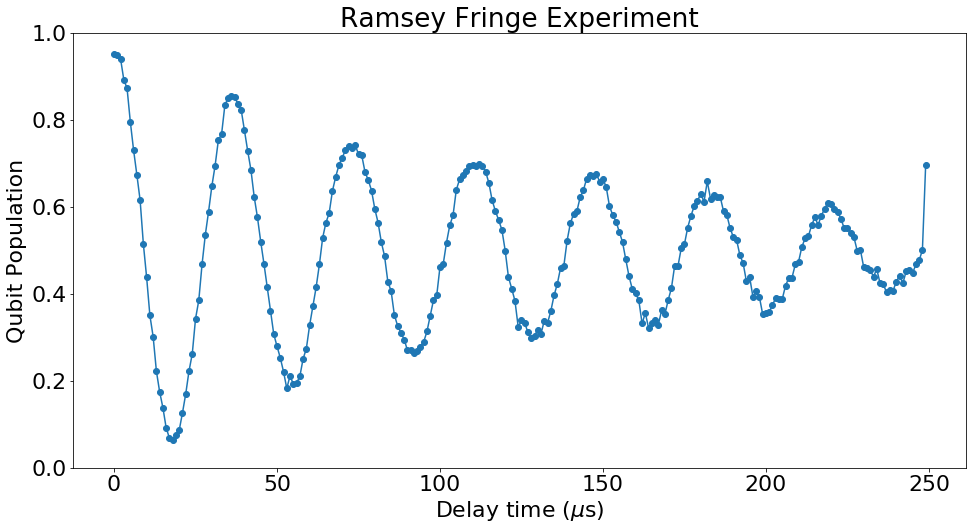

In [18]:
expt_cfg={"start":soccfg.us2cycles(0.0), "step":soccfg.us2cycles(1), "phase_step": soccfg.deg2reg(2*360/100, gen_ch=2), "expts":250,
          "reps": 10, "rounds": 200
       }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs
t2p=RamseyProgram(soccfg, config)
x_pts, avgi, avgq= t2p.acquire(soc, threshold=readout_cfg["threshold"],progress=True)

subplot(111, title="Ramsey Fringe Experiment", xlabel="Delay time ($\mu$s)", ylabel="Qubit Population")
plot(soccfg.cycles2us(x_pts),avgi[0][0],'o-')
ylim(0,1);

# Active reset

This experiment demonstrates active reset with the QICK. 

The protocol is as follows: there is an overall loop over the qubit drive pulse amplitude (as in the amplitude Rabi measurement above). During each loop iteration, several measurements occur. First, an amplitude rabi measurement is done (labeled "pre-reset" in the below plot). If that measurement doesn't exceed a threshold (meaning that the qubit is in its ground state after the qubit drive pulse was applied) nothing is done. But if the measurement exceeds the threshold (meaning that the the qubit is in its excited state after the qubit drive pulse was applied) a $\pi$ pulse is applied to the qubit (hopefully bringing it back to the gnd state). Finally, a second measurement is done (labeled "post-reset" in the below plot). 

Note that to run this experiment you must first successfully calibrate the single-shot readout threshold using the Single Shot experiment above. 

In [19]:
class ActiveResetProgram(RAveragerProgram):        
    def initialize(self):
        cfg=self.cfg
        
        self.q_rp=self.ch_page(self.cfg["qubit_ch"])     # get register page for qubit_ch
        self.r_gain=self.sreg(cfg["qubit_ch"], "gain")   # get frequency register for qubit_ch  
        
        self.r_gain2=4
        self.regwi(self.q_rp, self.r_gain2, cfg["start"])        

        self.r_thresh = 6
        self.regwi(0,self.r_thresh,config["threshold"]*cfg["readout_length"])
        
        self.declare_gen(ch=cfg["res_ch"], nqz=1) #Readout
        self.declare_gen(ch=cfg["qubit_ch"], nqz=2) #Qubit
        for ch in [0,1]: #configure the readout lengths and downconversion frequencies
            self.declare_readout(ch=ch, length=cfg["readout_length"],
                                 freq=cfg["f_res"], gen_ch=cfg["res_ch"])
        
        f_res=self.freq2reg(cfg["f_res"], gen_ch=cfg["res_ch"], ro_ch=0) # conver f_res to dac register value
        f_ge=self.freq2reg(cfg["f_ge"], gen_ch=cfg["qubit_ch"])

        # add qubit and readout pulses to respective channels
        self.add_gauss(ch=cfg["qubit_ch"], name="qubit", sigma=cfg["sigma"], length=cfg["sigma"]*4)
        self.set_pulse_registers(ch=cfg["qubit_ch"], style="arb", freq=f_ge, phase=0, gain=cfg["start"], 
                                 waveform="qubit")
        self.set_pulse_registers(ch=cfg["res_ch"], style="const", freq=f_res, phase=cfg["res_phase"], gain=cfg["res_gain"], 
                                 length=cfg["readout_length"])        
        
        self.sync_all(self.us2cycles(500))
    
    def body(self):
        self.mathi(self.q_rp,self.r_gain,self.r_gain2,"+",0)
        
        self.pulse(ch=self.cfg["qubit_ch"])  #play probe pulse
        self.sync_all(self.us2cycles(0.05))
        
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[0,1],
             adc_trig_offset=self.cfg["adc_trig_offset"])
        
        self.wait_all(200) # pause until 200 clocks past the end of the readout window
        self.read(0,0,"lower",2)
        self.read(0,0,"upper",3)
        self.condj(0,2,'<',self.r_thresh,'after_reset')

        self.regwi(self.q_rp, self.r_gain, self.cfg["pi_gain"])  #pi pulse qubit
        self.pulse(ch=self.cfg["qubit_ch"], t=0)

        self.label('after_reset')
        self.sync_all(self.us2cycles(1)) # align channels and wait 50ns

        #trigger measurement, play measurement pulse, wait for qubit to relax
        self.measure(pulse_ch=self.cfg["res_ch"], 
             adcs=[0,1],
             adc_trig_offset=self.cfg["adc_trig_offset"],
             wait=True,
             syncdelay=self.us2cycles(self.cfg["relax_delay"]))

    def update(self):
        self.mathi(self.q_rp, self.r_gain2, self.r_gain2, '+', self.cfg["step"]) # update frequency list index
        

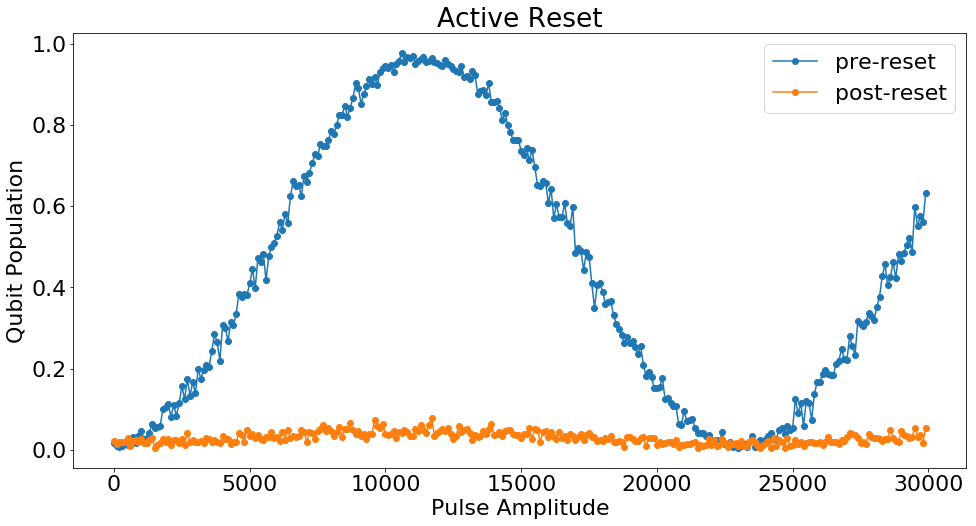

In [20]:
expt_cfg={
        "start":0, "step":100, "expts":300, "reps": 400
       }
config={**hw_cfg,**readout_cfg,**qubit_cfg,**expt_cfg} #combine configs

areset=ActiveResetProgram(soccfg, config)
expt_pts,avgi,avgq = areset.acquire(soc, threshold=readout_cfg["threshold"], progress=True)

subplot(111,title="Active Reset", xlabel="Pulse Amplitude", ylabel="Qubit Population")
plot(expt_pts,avgi[0][0],'o-', label="pre-reset")
plot(expt_pts,avgi[0][1], 'o-', label="post-reset")
legend();